In [1]:
f_name_out ="d:\\Master\\S2\\TER\\TEST_ROBIN\\ter-genetic-algorithm-leek-wars\\analyse\\src\\outcome_gen_turn\\57\\0\\LOST_LIFE.csv"

In [12]:
import ast

In [13]:
index_col_=[0, 1, 2, 3]

def convert_int_list(x):
    return ast.literal_eval(x)

str_col_='LOST_LIFE'

In [14]:
import pandas as pd

In [15]:
df = pd.read_csv(f_name_out,index_col=index_col_,sep=";",encoding="utf-8",converters={str_col_: convert_int_list})

In [16]:
i=0
batch_size = 2500

In [18]:
display(df)

LOST_LIFE
ID_GEN ID_FIGHT ID_ENTITY ID_TURN          
287    70       10        1             [0]
                24        1             [0]
                10        2             [0]
                24        2             [0]
                10        3             [7]
                24        3            [97]
                10        4           [260]
                24        4           [265]
                10        5           [155]
286    73       17        1             [0]
                22        1             [0]
                17        2             [0]
                22        2             [0]
                17        3            [64]
                22        3            [43]
                17        4           [260]
                22        4           [265]
                17        5            [96]

In [19]:

batch = df.loc[df.index[i:i+batch_size-1], str_col_].tolist()

In [21]:
import pandas as pd 
import json
from myutil  import *
import os 
import numpy as np


'''
ReadActions :
    - STATIC :
        - MAP_SIZE : nombre de cases sur la map
        - intervals_ends : fin des intervalles des types d'actions ( e.g Times : 100 ,  Buffs: 200 , ... )
        - intervals_dict : dictionnaire inversé de intervals_dict ( e.g { {START_FIGHT: 0 ,...,USE_WEAPON: 16  , LOST_PT : 100 , ... , NOVA_VITALITY :  112 , ... }  }# le fichier filename_dfActions loader 
        - intervals_dictRev : dictionnaire des types d'actions ( e.g {0:START_FIGHT ,...,16: USE_WEAPON , ... } # le fichier filename_dfActions loader reversed
        - filename_dfActions : nom du fichier json contenant les actions de chaque types d'actions ainsi que la taille des intervalles 
        - ex_idx : liste des index des membres du json  a exclure (e.g [0,2,3]<=> interval_size , Funs , Others )
        - lst_col : liste des colonnes non calculer (directement accessible via l'outcome ) à stocker dans le dataframe
        - id_col : liste des colonnes contenant les ids identifiants les lignes du dataframe
        - deg_col : liste des colonnes contenant les degats infligés ou subis par les entités (parmis les colonnes décritent dans lst_col)
        - audit_col : liste des types d'actions performer pendant le tour (e.g [0,0,1,2,1,1] <=> [df.cols[0] , df.cols[0], df.cols[1] , ...] <=> [Times , Times , Buffs , ...])

    - NON STATIC :
        - numGen : numéro de la génération
        - numFight : numéro du combat
        - beg_notCodeAct_col : index indiquant le début des colonnes qui ne sont pas des liste de codes d'actions
        - entities_ids : les ids réelle des entités (telle que spécifié dans le scénario["entities"][i]["id"] ) impliquées dans le fight du dataframe 
        - int_col_idx_in_lst_col : liste des index des colonnes contenant des ints dans lst_col 

'''
class ReadActions :
    MAP_SIZE = 612 
    intervals_ends = dict()
    intervals_dict = dict()
    intervals_dictRev = dict()  
    filename_dfActions = os.path.join("..","data","df_Action.json")
    filename_dfValueActions = os.path.join("..","data","df_value_Action.json")
    
    dict_dfValue = json.load(open( filename_dfValueActions))
    ex_idx = [0,2,3]
    lst_col = ['LOST_LIFE','LIFE','MOVE_TO','WEAPON_DEG','CHIP_DEG','MAPS','WEAPON_ID','CHIP_ID']
    id_col = ['ID_GEN','ID_FIGHT','ID_ENTITY','ID_TURN']
    deg_col = ['LOST_LIFE','LIFE','WEAPON_DEG','CHIP_DEG']
    audit_col = ["ACTIONS"]
    
    #maps = [ [0]*MAP_SIZE ,[0]*MAP_SIZE]
    
    def __init__(self,ids :list ,numGen :int , numFight:int ,path_atm :str ):
        self.numGen = numGen
        self. numFight = numFight
        self.numTurn = 0
        ReadActions.init_intervals(ReadActions.filename_dfActions)#,ReadActions.ex_idx)
        self.nb_type = len(ReadActions.intervals_ends)
        self.lst_col_code = [list(ReadActions.intervals_ends.keys())[i] for i in range(1,len(ReadActions.intervals_ends)) ] 
        self.df = pd.DataFrame(columns=self.lst_col_code+ReadActions.lst_col+ReadActions.id_col+ReadActions.audit_col)
        self.beg_notCodeAct_col = len(self.df.columns) - len(ReadActions.lst_col)-len(ReadActions.id_col)-1
        self.entities_ids = ids 
        self.setIntCol()
        
    def setDF(self,df2):
        if(df2.columns == self.df.columns):
            self.df = pd.concat([self.df , df2])
            
        
    def setIntCol(self):
        self.int_col_idx_in_lst_col = []
        for i,d in enumerate(self.df.columns.tolist()) :
            if d in ReadActions.deg_col :
                self.int_col_idx_in_lst_col+=[i]
        self.int_col_idx_in_lst_col.sort()


    @property
    def getNumGen(self):
        return self.numGen
    
    @property
    def getNumFight(self):
        return self.numFight
    
    @property
    def getNumTurn(self):
        return self.numTurn
    
    @property
    def getDF(self):
        return self.df
    
    @property
    def getEntitiesIds(self):
        return self.entities_ids
    



    @staticmethod
    def emptyIntervalsEnd():
            ReadActions.intervals_ends.update({'BEGIN':0})


    
    @staticmethod
    def init_intervals(filename_json_dfA :str ,ex_idx=[]):
            """
            filename_json_dfA : fichier json contenant les actions de chaque types d'actions ainsi que la taille des intervalles
            ex_idx : liste des index des membres du json  a exclure (e.g [0,2,3]<=> interval_size , Funs , Others )

            Description : initialise les attributs intervals_dict , intervals_dictRev , intervals_ends de la classe ReadActions grâce au fichier json passer en paramètre
            """
            if( isJsonFile( filename_json_dfA ) ):
                ReadActions.emptyIntervalsEnd()
                #Load json file
                with open(filename_json_dfA, 'r') as f:
                    df_actions_json = json.load(f)
                interval_size = df_actions_json["interval_size"]

                #ignore interval_size from dictionnary
                del df_actions_json["interval_size"]

                #ignore ex_idx from dictionnary
                for to_ignore in ex_idx :
                    del df_actions_json[to_ignore]

                #extract info from dict and load it in class attributes 

                idx_keyOf_action = 0
                idx_intcodeOf_action = 1
                for i,group_of_actions in enumerate(df_actions_json.items())  :
                    id_group,lst_actions=group_of_actions
                    
                    for action in lst_actions.items():
                        ReadActions.intervals_dict.update({action[idx_keyOf_action]:action[idx_intcodeOf_action]})

                    ReadActions.intervals_ends.update({id_group:(interval_size+1)*(i+1)})
                ReadActions.intervals_dictRev = reversedict(ReadActions.intervals_dict)
            else :
                errorMessagePyth("file"+filename_json_dfA+" must be a json file")
        
     
    
    @staticmethod
    def whileToken(str_token : str , lst_actions :list ):
        """
        str_token : le string correspondant au token a chercher dans lst_actions ( un token est exprimer sous la forme d'un int dans lst_actions)
        lst_actions : liste d'actions  a parcourir   ( lst_action[i][0] == code_token ) 

        Description : parcours lst_actions jusqu'a ce que le token soit trouvé ou que la fin de la liste soit atteinte 
        Return : l'index de l'action token dans lst_actions tel que ( lst_action[index][0] == code_token )  ou -1 si le token n'a pas été trouvé
        """
        for i in range(len(lst_actions)) :
            action = lst_actions[i]
            if(action[0] == ReadActions.intervals_dict.get(str_token)):
                i+=1
                return i
        return notFound()
    

    @staticmethod        
    def isEndFight(act_token: int):
        return act_token == ReadActions.intervals_dict.get("END_FIGHT")
    
    @staticmethod 
    def isBeginFight(act_token: int):
        return act_token == ReadActions.intervals_dict.get("START_FIGHT")
    
    @staticmethod 
    def isBeginTurn(act_token: int):
        return act_token == ReadActions.intervals_dict.get("NEW_TURN")
    
    @staticmethod 
    def isEndTurn(act_token: int):
        return ReadActions.isEndFight(act_token) or ReadActions.isBeginTurn(act_token ) or act_token == ReadActions.intervals_dict.get("END_TURN")
    

    @staticmethod
    def getDfLstTypeActions():
        return list([[]])
    
    @staticmethod
    def getDfLstAudit():
        return list([[]])
    
    @staticmethod
    def getDfLstInLstCol():
        return [0]
    
    @staticmethod
    def getDfLstNotInLstCol():
        return []
    

    def getNewRow(self):
        lst =[]

        #-----------------Type Actions [Times,Buffs , ... ] -----------------
        idx = 0 
        idx_end = self.beg_notCodeAct_col 
        #Type of actions , e.g Times,Buffs,Funs,Effects , Others 
        for i in range (idx,idx_end):
            lst.append(ReadActions.getDfLstTypeActions())

        t=0
        #----------------- Lst Col -----------------
        idx = idx_end
        idx_end +=len(ReadActions.lst_col)
        for i in range (idx , idx_end):
            if i in self.int_col_idx_in_lst_col[t:] :
                lst.append(ReadActions.getDfLstInLstCol())
                t+=1
            #elif ReadActions.lst_col[i-idx] in ["WEAPON_ID","CHIP_ID"]:
            #    lst.append(notSetId())
            else :
                lst.append(ReadActions.getDfLstNotInLstCol())

        #----------------- Not in Lst Col -----------------
        idx = idx_end
        idx_end += len(ReadActions.id_col)
        for i in range (idx ,  idx_end):
            lst.append(notSetId())

        #----------------- Audit -----------------
        idx = idx_end
        idx_end += len(ReadActions.audit_col)
        for i in range (idx,idx_end):
            lst.append(ReadActions.getDfLstAudit())#actions



        return lst
    
    def idxNextRow(self):
        return self.getCurrentIDX()+1
    
    def addNewRow(self):
        self.df.loc[self.idxNextRow()]=self.getNewRow()
    
        
    def addNewTurn(self,idx_turn: int):
        """
        idx_turn : index du tour a ajouter
        Description : ajoute une nouvelle ligne et set sont indexe de tour à idx_turn
        """
        self.addNewRow()
        #self.numTurn = idx_turn
        self.setColumn ('ID_TURN', idx_turn )
        
    def getCurrentIDX (self):
        return len(self.df)-1

    def setColumn ( self , str_col:str ,val):
        """
        Description : set la colonne str_col de la ligne courante à val
        """
        if ( strColInCols(str_col ,self.df)):
            self.df.loc[self.getCurrentIDX(),str_col]= val 
    

    def addToColumn(self,str_col:str,val,pos:int=0):
        """
        val : valeur a ajouter a la liste de la colonne str_col de la ligne courante
        pos : position de la valeur a ajouter dans la liste de la colonne str_col de la ligne courante (par defaut 0)

        Description : ajoute une valeur a la liste de la colonne str_col de la ligne courante
        """
        if (strColInCols(str_col ,self.df)):
            lst=self.df.loc[self.getCurrentIDX(),str_col]

            if( len(lst )< pos):
                errorMessagePyth(self,"addToColumn" , "index out of range")

            if( not(bool(lst)) or len(lst )== pos):
                lst+=[0]
            
            lst[pos]+= val  

        return pos 
            
            
    def addToColumnList(self,str_col:str,val,pos:int=0):
        """
        Attention : on embedde la valeur dans une liste car la colonne str_col est de type liste 
        """
        if(len(self.df[str_col]) == 0  or not(isinstance(self.df[str_col][0],list))):
            errorMessagePyth(self,"addToColumnList" , "column "+str_col+" must be a list")
            return badInsert()
        else :
            return self.addToColumn(str_col , [val],pos) 

    def extendColum(self,str_col:str,val:list):
        """
        Description : on ajoute une liste a la liste de la colonne str_col de la ligne courante
        """
        if (strColInCols(str_col ,self.df)):
            self.df.loc[self.getCurrentIDX(),str_col].extend(val)
       

    def addToAudit(self , idx:int , idx_of_actionType :int ,   act_token:int  ):
        """
        Description : on ajoute l'index du type de l'action courante dans la colonne audit correspondante
        """
        err_code=self.addToColumnList (  ReadActions.audit_col[idx],idx_of_actionType)
        if(err_code == badInsert()):
            errorMessagePyth(self, "addToCategory" , "bad insert")
            
    def addToGroupAction(self,idx_of_actionType:int , act_token:int):
        err_code = self.addToColumnList (list(ReadActions.intervals_ends.keys())[idx_of_actionType],act_token)
        if(err_code == badInsert()):
            errorMessagePyth(self, "addToCategory" , "bad insert")




    def setIDs(self,entity_id:int):
        """
        Description : set les colonnes IDs de la ligne courante sauf ID_TURN 
        """
        self.setColumn ('ID_GEN',self.numGen)
        self.setColumn ('ID_FIGHT',self. numFight)
        self.setColumn ('ID_ENTITY',self.getEntityID(entity_id))
        #self.setColumn ('ID_TURN',self.idx_turn)
        
    def getEntityID(self ,entity_id:int ):
        """
        Description : retourne l'ID de l'entité entity_id si elle existe sinon retourne outOfRange()
        """
        if len(self.entities_ids) > entity_id :
            return self.entities_ids[entity_id]
        
        else :
            errorMessagePyth(self,"getEntityID" , "index out of range")
            return outOfRange()
        
    @staticmethod
    def getIdxCodeToken():
        return 0
    @staticmethod
    def getIdxEntityToken():
        return 1
    
    @staticmethod
    def getCodeToken(_lst :list):
        return _lst[ReadActions.getIdxCodeToken()]
    @staticmethod
    def getEntityToken(_lst :list):
        return _lst[ReadActions.getIdxEntityToken()]
    
    def getTurn( self,lst_actions :list ,idx_turn :int ):
        entity_id = -1 
        
        # continue jusqu'au token LEEK_TURN
        nbActionRead=ReadActions.whileToken("LEEK_TURN",lst_actions)

        k = nbActionRead

        if(k==notFound()):
            return k , None 
        
        act_token = ReadActions.getCodeToken(lst_actions[k])
        entity_id =  ReadActions.getEntityToken(lst_actions[k-1])
        
        self.addNewTurn(idx_turn)
        self.setIDs(entity_id)

        #si le tour est vide : 
        if(self.isEndTurn(act_token)):
            return k , entity_id 
        
        idx=0
        while k  < len(lst_actions):

            act_token = ReadActions.getCodeToken(lst_actions[k])

            #si le tour est fini : 
            if(self.isEndTurn(act_token) ):
                return k , entity_id
            

            for i in range(1,len(ReadActions.intervals_ends)):
                #idx_group_actions=i
                interval = [list(ReadActions.intervals_ends.values())[i-1],list(ReadActions.intervals_ends.values())[i]]
                if(act_token  in ReadActions.intervals_dictRev and isInInterval(act_token , interval )) :
                    
                    _id = ReadActions.getEntityToken(lst_actions[k])
                    self.addToAudit(ReadActions.audit_col.index("ACTIONS"),i,act_token)
                    self.addToGroupAction(i , act_token)

        

                    if(list(ReadActions.intervals_ends.keys())[i] == "Times"):

                        if(ReadActions.intervals_dictRev.get(act_token) == "MOVE_TO"):
                            lst_mv = lst_actions[k][ReadActions.dict_dfValue[str(act_token)]["name_fields"].index("path")]
                            self.extendColum('MOVE_TO',[lst_mv[0],len(lst_mv),lst_mv[-1]])
                            self.extendColum('MAPS',lst_mv)
                            
  
                            
                    elif(list(ReadActions.intervals_ends.keys())[i] == "Buffs"):
                        if(ReadActions.intervals_dictRev.get(act_token) == 'HEAL'):
                            self.addToColumn('LIFE',lst_actions[k][ReadActions.dict_dfValue[str(act_token)]["name_fields"].index("life")])
                        elif(ReadActions.intervals_dictRev.get(act_token) in ['LOST_LIFE','NOVA_DAMAGE','DAMAGE_RETURN','LIFE_DAMAGE','POISON_DAMAGE',' AFTEREFFECT']):
                            self.addToColumn('LOST_LIFE',lst_actions[k][ReadActions.dict_dfValue[str(act_token)]["name_fields"].index("pv")])
                    elif(list(ReadActions.intervals_ends.keys())[i] == "Effects"):
                        if(ReadActions.intervals_dictRev.get(act_token) == 'ADD_WEAPON_EFFECT'):
                            self.addToColumn('WEAPON_DEG',lst_actions[k][ReadActions.dict_dfValue[str(act_token)]["name_fields"].index("value")])
                            self.extendColum('WEAPON_ID',[_id])
                        elif(ReadActions.intervals_dictRev.get(act_token) == 'ADD_CHIP_EFFECT'):
                                self.addToColumn('CHIP_DEG',lst_actions[k][ReadActions.dict_dfValue[str(act_token)]["name_fields"].index("value")])
                                self.extendColum('CHIP_ID',[_id])
                                
                    
                    
            k+=1
            idx+=1
        return k , entity_id

                            
                    
    def getFight ( self,lst_actions:list ):
        nbReads=ReadActions.whileToken("START_FIGHT",lst_actions)

        k=nbReads

        idx_turn = 0 
        while k < len(lst_actions):
            act_token =ReadActions.getCodeToken(lst_actions[k])
            if(self.isEndFight(act_token )):
                return k 
            nbReads , ent_id = self.getTurn(lst_actions[k:],idx_turn)
            if(nbReads==-1):
                break
            k+=(nbReads+1)
            if(k < len(lst_actions)):
                act_token =ReadActions.getCodeToken(lst_actions[k])
                if(self.isBeginTurn(act_token)):
                    idx_turn +=1


In [38]:
def getMaxID(str_col):
    path_data = "D:\\Master\\S2\\TER\\TEST_ROBIN\\ter-genetic-algorithm-leek-wars\\analyse\\data"
    if(str_col == "MAPS"):
        return [i for i in range(612)]
    if(str_col == "WEAPON_ID"):
        dct_ = json.load(open(os.path.join(path_data,"weapons"+".json")))
        return list(map(int,list(dct_.keys())))
    if(str_col == "CHIP_ID"):
        dct_ = json.load(open(os.path.join(path_data,"chips"+".json")))
        return list(map(int,list(dct_.keys())))

In [84]:
from collections import Counter
#dict_part={"PART_TURN":0,"PART_GEN":6}
def df_lst_col (path_root_f_  ,dict_part,index_col_=[i for i in range(len(ReadActions.id_col))],ignore_col = ["MOVE_TO"]):

    path_f= os.path.join(os.path.join(path_root_f_ ,str(dict_part["PART_GEN"])),str(dict_part["PART_TURN"]))
    
    for str_col_ in list(set(ReadActions.lst_col) - set(ReadActions.deg_col) ):

        if(not(str_col_ in ignore_col )):
            acc_counter = Counter()
            f_name_out = os.path.join(path_f ,str_col_)+".csv"

            df = pd.read_csv(f_name_out,index_col=index_col_,sep=";",encoding="utf-8",converters={str_col_: convert_int_list})#DataFrame({'data': [np.random.randn(3) for i in range(N)]})

            batch_size = 2500

            for i in range(0, len(df), batch_size):

                batch = df.loc[df.index[i:i+batch_size-1], str_col_].tolist()

                batch_size = len(batch)


                # Concaténation des listes
                concatenated_data = np.concatenate(batch)
                my_counter = Counter(concatenated_data)

                acc_counter += my_counter

            res_counter = Counter({i: 0 for i in getMaxID(str_col_)})
            res_counter.update(acc_counter)
            res_counter.update(dict_part)
            #res_counter.update({"PART_GEN":part_gen_})
            
            res_counter = {str(k): v for k, v in res_counter.items()}
            
            
            path_f_csv = os.path.join(path_root_f_,str_col_+'.csv')
            try:
                df_write = pd.read_csv(path_f_csv ,sep=";",encoding="utf-8", index_col=[0])
            except :
                df_write = pd.DataFrame(columns=list(res_counter.keys()))

            
            # Append the new row to the DataFrame
            #df_write = df_write.append(res_counter,ignore_index=True)
            

            
            df_dct_ = pd.DataFrame([res_counter])
            
            df_write =pd.concat([df_write, df_dct_],ignore_index=True)
            
            
            display(df_write)
            

            # Write the DataFrame back to the CSV file
            df_write.to_csv(path_f_csv ,sep=";",encoding="utf-8")
        

In [85]:
arr_maps = [{"PART_GEN" :12 , "PART_TURN" : 0 },
{"PART_GEN" :20 , "PART_TURN" :0},
{"PART_GEN" : 45 , "PART_TURN" : 0 }]

In [86]:
path_root_= "D:\\Master\\S2\\TER\\TEST_ROBIN\\ter-genetic-algorithm-leek-wars\\analyse\\src\\outcome_gen_turn"

In [87]:
for e in arr_maps :
    df_lst_col (path_root_, e )

,0,1,2,3,4,5,6,7,8,9,...,604,605,606,607,608,609,610,611,PART_GEN,PART_TURN


,0,1,2,3,4,5,6,7,8,9,...,604,605,606,607,608,609,610,611,PART_GEN,PART_TURN
0,0,11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12,0


,1,10,11,12,13,14,15,16,17,18,...,32,4,5,6,7,8,9,108.0,PART_GEN,PART_TURN


,1,10,11,12,13,14,15,16,17,18,...,32,4,5,6,7,8,9,108.0,PART_GEN,PART_TURN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,578,12,0


,1,10,100,101,102,103,104,105,106,11,...,92,93,94,95,96,97,98,99,PART_GEN,PART_TURN


,1,10,100,101,102,103,104,105,106,11,...,92,93,94,95,96,97,98,99,PART_GEN,PART_TURN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,124,33,0,0,12,0


ICI


,0,1,2,3,4,5,6,7,8,9,...,604,605,606,607,608,609,610,611,PART_GEN,PART_TURN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,20,0


,0,1,2,3,4,5,6,7,8,9,...,604,605,606,607,608,609,610,611,PART_GEN,PART_TURN
0,0,11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12,0


,0,1,2,3,4,5,6,7,8,9,...,604,605,606,607,608,609,610,611,PART_GEN,PART_TURN
0,0,11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,20,0


ICI


,1,10,11,12,13,14,15,16,17,18,...,32,4,5,6,7,8,9,108.0,PART_GEN,PART_TURN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,550,20,0


,1,10,11,12,13,14,15,16,17,18,...,32,4,5,6,7,8,9,108.0,PART_GEN,PART_TURN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,578,12,0


,1,10,11,12,13,14,15,16,17,18,...,32,4,5,6,7,8,9,108.0,PART_GEN,PART_TURN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,578,12,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,550,20,0


ICI


,1,10,100,101,102,103,104,105,106,11,...,92,93,94,95,96,97,98,99,PART_GEN,PART_TURN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,217,3,0,0,20,0


,1,10,100,101,102,103,104,105,106,11,...,92,93,94,95,96,97,98,99,PART_GEN,PART_TURN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,124,33,0,0,12,0


,1,10,100,101,102,103,104,105,106,11,...,92,93,94,95,96,97,98,99,PART_GEN,PART_TURN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,124,33,0,0,12,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,217,3,0,0,20,0


ICI


,0,1,2,3,4,5,6,7,8,9,...,604,605,606,607,608,609,610,611,PART_GEN,PART_TURN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,45,0


,0,1,2,3,4,5,6,7,8,9,...,604,605,606,607,608,609,610,611,PART_GEN,PART_TURN
0,0,11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,20,0


,0,1,2,3,4,5,6,7,8,9,...,604,605,606,607,608,609,610,611,PART_GEN,PART_TURN
0,0,11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,20,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,45,0


ICI


,1,10,11,12,13,14,15,16,17,18,...,32,4,5,6,7,8,9,108.0,PART_GEN,PART_TURN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,854,45,0


,1,10,11,12,13,14,15,16,17,18,...,32,4,5,6,7,8,9,108.0,PART_GEN,PART_TURN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,578,12,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,550,20,0


,1,10,11,12,13,14,15,16,17,18,...,32,4,5,6,7,8,9,108.0,PART_GEN,PART_TURN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,578,12,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,550,20,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,854,45,0


ICI


,1,10,100,101,102,103,104,105,106,11,...,92,93,94,95,96,97,98,99,PART_GEN,PART_TURN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,61,0,0,0,45,0


,1,10,100,101,102,103,104,105,106,11,...,92,93,94,95,96,97,98,99,PART_GEN,PART_TURN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,124,33,0,0,12,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,217,3,0,0,20,0


,1,10,100,101,102,103,104,105,106,11,...,92,93,94,95,96,97,98,99,PART_GEN,PART_TURN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,124,33,0,0,12,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,217,3,0,0,20,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,61,0,0,0,45,0


In [42]:
import os 
path_correl_folder = "D:\\Master\\S2\\TER\\analyse\\src\\Dataset_1\\correl"

path_correl_file = os.path.join(path_correl_folder,"1_correl.csv")

In [43]:
import pandas as pd 
from ast import literal_eval

df = pd.read_csv(path_correl_file,encoding="utf-8",sep=";")
display(df)

,STRENGTH,AGILITY,FREQUENCY,WISDOM,ABSOLUTE_SHIELD,RELATIVE_SHIELD,RESISTANCE,SCIENCE,MAGIC,DAMAGE_RETURN,POWER,ID_GEN,ID_FIGHT,ID_ENTITY
0,"[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]",345,0,62
1,"[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]",345,0,12
2,"[936, 1638]","[936, 1638]","[936, 1638]","[936, 1638]","[936, 1638]","[936, 1638]","[936, 1638]","[936, 1638]","[936, 1638]","[936, 1638]","[936, 1638]",345,1,62
3,"[936, 1638]","[936, 1638]","[936, 1638]","[936, 1638]","[936, 1638]","[936, 1638]","[936, 1638]","[936, 1638]","[936, 1638]","[936, 1638]","[936, 1638]",345,1,12
4,"[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]","[944, 1652]",345,2,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4421,"[872, 1526]","[872, 1526]","[872, 1526]","[872, 1526]","[872, 1526]","[872, 1526]","[872, 1526]","[872, 1526]","[872, 1526]","[872, 1526]","[872, 1526]",358,117,12
4422,"[630, 1260]","[630, 1260]","[630, 1260]","[630, 1260]","[630, 1260]","[630, 1260]","[630, 1260]","[630, 1260]","[630, 1260]","[630, 1260]","[630, 1260]",358,118,62
4423,"[630, 1260]","[630, 1260]","[630, 1260]","[630, 1260]","[630, 1260]","[630, 1260]","[630, 1260]","[630, 1260]","[630, 1260]","[630, 1260]","[630, 1260]",358,118,12
4424,"[784, 1372]","[784, 1372]","[784, 1372]","[784, 1372]","[784, 1372]","[784, 1372]","[784, 1372]","[784, 1372]","[784, 1372]","[784, 1372]","[784, 1372]",358,119,62


In [128]:
 
def ratio_col (df_ ,cols ):
    df = df_.copy()
    for i , r in df.iterrows():
        for str_col in cols:
            pair = literal_eval(r[str_col])
            df.loc[i, str_col+'_RATIO'] = int(pair[0])/int(pair[1]) if int(pair[1]) != 0 else 0
    return df 


In [129]:

cols_value = df.columns[:-3]
df_ratio = ratio_col(df,cols_value)

In [130]:
ratio_and_ids = list(set(list(df_ratio.columns))- set(list( cols_value)))

In [131]:
df_only_ratio = df_ratio[ratio_and_ids ]

In [132]:
ids_value =  df.columns[-3:]
ratio_cols = list(set(list(ratio_and_ids)) - set(list(ids_value)))

In [133]:
from os import listdir
from os.path import isfile, join

In [ ]:
def _funf ():

    final_df_maps=None
    col_files = [f for f in listdir(path_correl_folder) if isfile(join(path_correl_folder, f))]
    for file in col_files:
        path_file = os.path.join(path_correl_folder,file)
        print(path_file)
        
        df = pd.read_csv(path_file,encoding="utf-8",sep=";")
        
        

        cols_value = df.columns[:-3]
        df_ratio = ratio_col(df,cols_value)
        
        ratio_and_ids = list(set(list(df_ratio.columns))- set(list( cols_value)))
        
        df_only_ratio = df_ratio[ratio_and_ids ]
        
        ids_value =  df.columns[-3:]
        ratio_cols = list(set(list(ratio_and_ids)) - set(list(ids_value)))
        
        group_cols =["ID_GEN"]
        not_grouped_cols = set(list(ids_value)) -set(group_cols)
        
        final_df_maps = pd.DataFrame( columns=ratio_cols+group_cols) if final_df_maps is None else final_df_maps
        
        df_only_ratio.drop(not_grouped_cols, axis=1)
        grouped= df_only_ratio.groupby(group_cols)
        for name, group in grouped:
                        if isinstance(name,list) : 
                            __lst = [ name[i] for i in range(len(group_cols)) ] 

                        else :
                            __lst = [name]
                            if(isinstance(name,tuple)):
                                __lst = list(*__lst)


                        try:
                            final_df_maps.loc[len(final_df_maps)]=  group[ratio_cols].mean().values.tolist() + __lst
                        except:
                            print( __lst)
                            print(group[ratio_cols].sum().values.tolist()+ __lst)
                            print(final_df_maps.columns)
                            return 0
        print(set(list(final_df_maps["ID_GEN"])))
        grouped= final_df_maps.groupby(group_cols)
        total_df= pd.DataFrame( columns=final_df_maps.columns)
       
        for name, group in grouped:
                        if isinstance(name,list) : 
                            __lst = [ name[i] for i in range(len(group_cols)) ] 

                        else :
                            __lst = [name]
                            if(isinstance(name,tuple)):
                                __lst = list(*__lst)


                        try:
                            total_df.loc[len(total_df)]=  group[ratio_cols].mean().values.tolist() + __lst
                        except:
                            print( __lst)
                            print(group[ratio_cols].sum().values.tolist()+ __lst)
                            print(total_df.columns)
                            return 0
            
    return total_df
dfui_ = _funf ()

In [159]:
df_copy_ = dfui_.copy()
display(dfui_)

,SCIENCE_RATIO,STRENGTH_RATIO,FREQUENCY_RATIO,AGILITY_RATIO,RESISTANCE_RATIO,RELATIVE_SHIELD_RATIO,WISDOM_RATIO,DAMAGE_RETURN_RATIO,MAGIC_RATIO,POWER_RATIO,ABSOLUTE_SHIELD_RATIO,ID_GEN
0,0.566670,0.566670,0.566670,0.566670,0.566670,0.566670,0.566670,0.566670,0.566670,0.566670,0.566670,31.0
1,0.566600,0.566600,0.566600,0.566600,0.566600,0.566600,0.566600,0.566600,0.566600,0.566600,0.566600,32.0
2,0.568571,0.568571,0.568571,0.568571,0.568571,0.568571,0.568571,0.568571,0.568571,0.568571,0.568571,33.0
3,0.561064,0.561064,0.561064,0.561064,0.561064,0.561064,0.561064,0.561064,0.561064,0.561064,0.561064,34.0
4,0.561858,0.561858,0.561858,0.561858,0.561858,0.561858,0.561858,0.561858,0.561858,0.561858,0.561858,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...
207,0.535555,0.535555,0.535555,0.535555,0.535555,0.535555,0.535555,0.535555,0.535555,0.535555,0.535555,354.0
208,0.531492,0.531492,0.531492,0.531492,0.531492,0.531492,0.531492,0.531492,0.531492,0.531492,0.531492,355.0
209,0.557644,0.557644,0.557644,0.557644,0.557644,0.557644,0.557644,0.557644,0.557644,0.557644,0.557644,356.0
210,0.532483,0.532483,0.532483,0.532483,0.532483,0.532483,0.532483,0.532483,0.532483,0.532483,0.532483,357.0


In [160]:
len(dfui_["ID_GEN"])

212

In [161]:
_cols = list(set(list(dfui_.columns)) -set(["ID_GEN"]))

In [162]:
import json 
genetic_path = "D:\\Master\\S2\\TER\\analyse\\src"

pathGeneticScript =   os.path.join(genetic_path,"genetic-script-data")
settings_path = os.path.join(pathGeneticScript,"settings-genetic.json")
settings = json.load(open(settings_path))

In [163]:

## GENERATION  SETTING
nbMaxRow = 250000
nbPartTurn = 32

len_population = settings["population"]
len_maxturn = settings["mapStats"]["max_turns"]
nbGeneration=settings["generations"]

combat_quantity=settings["combatsQuantity"]

## BATCH SOTRING SETTING


len_part_turn = len_maxturn // nbPartTurn
u_tmp = nbMaxRow //(len_part_turn*len_population*combat_quantity)
nbPartGen = u_tmp if u_tmp <nbGeneration and   nbGeneration //u_tmp > 100  else 100
len_part_gen =  nbGeneration//nbPartGen

In [164]:
df_p = pd.DataFrame( columns=["LST_"+str(e) for e in _cols]+["PART_GEN"])
for i in range(nbPartGen):
    df_p.loc[i] = [[] for _ in range (len(_cols))]+[i]

In [165]:
vals_i = dfui_.columns[-1]

In [166]:
df_p_copy = df_p.copy()

In [172]:
df_p_copy_2= df_p_copy.copy()

In [ ]:
for i,r in dfui_.iterrows():
    part_gen = r["ID_GEN"]/len_part_gen 
    idx_gen = int(part_gen)
    listes = df_p_copy.loc[idx_gen].values.tolist()[:-1]
    nombres = r[:-1]
    for z in range(len(listes)):
        for nombre in nombres:
            listes[z].append(nombre)
    df_p_copy.loc[idx_gen] = listes +[idx_gen]
    



In [181]:
df_p_copy.to_csv("test_u.csv",encoding="utf-8",sep=";")

In [186]:
df_p_copy

,LST_SCIENCE_RATIO,LST_STRENGTH_RATIO,LST_FREQUENCY_RATIO,LST_AGILITY_RATIO,LST_RESISTANCE_RATIO,LST_RELATIVE_SHIELD_RATIO,LST_WISDOM_RATIO,LST_DAMAGE_RETURN_RATIO,LST_MAGIC_RATIO,LST_POWER_RATIO,LST_ABSOLUTE_SHIELD_RATIO,PART_GEN
0,[],[],[],[],[],[],[],[],[],[],[],0
1,[],[],[],[],[],[],[],[],[],[],[],1
2,[],[],[],[],[],[],[],[],[],[],[],2
3,[],[],[],[],[],[],[],[],[],[],[],3
4,[],[],[],[],[],[],[],[],[],[],[],4
...,...,...,...,...,...,...,...,...,...,...,...,...
95,[],[],[],[],[],[],[],[],[],[],[],95
96,[],[],[],[],[],[],[],[],[],[],[],96
97,[],[],[],[],[],[],[],[],[],[],[],97
98,[],[],[],[],[],[],[],[],[],[],[],98


In [ ]:
import numpy as np 

df_means =  pd.DataFrame( columns= [ e.replace("LST", "MEAN") for e in df_p_copy.columns] )
print(df_means.columns)
for i,r in df_p_copy.iterrows():
    col_means = {}
    for z, col in enumerate(df_p_copy.columns):
        if col != "PART_GEN":
            col_means[df_means.columns[z]] = np.array(r[col]).mean() if len(r[col]) > 0 else np.nan
        else:
            col_means[col] = r[col]
    df_means=df_means.append(col_means , ignore_index=True)

In [212]:
df_means["PART_GEN"]=df_means["PART_GEN"].astype(int)

In [213]:
df_means

,MEAN_SCIENCE_RATIO,MEAN_STRENGTH_RATIO,MEAN_FREQUENCY_RATIO,MEAN_AGILITY_RATIO,MEAN_RESISTANCE_RATIO,MEAN_RELATIVE_SHIELD_RATIO,MEAN_WISDOM_RATIO,MEAN_DAMAGE_RETURN_RATIO,MEAN_MAGIC_RATIO,MEAN_POWER_RATIO,MEAN_ABSOLUTE_SHIELD_RATIO,PART_GEN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97
98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98


In [214]:
df_means.to_csv("test_means.csv",encoding="utf-8",sep=";")

In [221]:
s_path = "D:\\Master\\S2\\TER\\analyse\\src\\plot\\correl"

In [222]:
df_means.columns[:-1]

Index(['MEAN_SCIENCE_RATIO', 'MEAN_STRENGTH_RATIO', 'MEAN_FREQUENCY_RATIO',
       'MEAN_AGILITY_RATIO', 'MEAN_RESISTANCE_RATIO',
       'MEAN_RELATIVE_SHIELD_RATIO', 'MEAN_WISDOM_RATIO',
       'MEAN_DAMAGE_RETURN_RATIO', 'MEAN_MAGIC_RATIO', 'MEAN_POWER_RATIO',
       'MEAN_ABSOLUTE_SHIELD_RATIO', 'PART_GEN'],
      dtype='object')

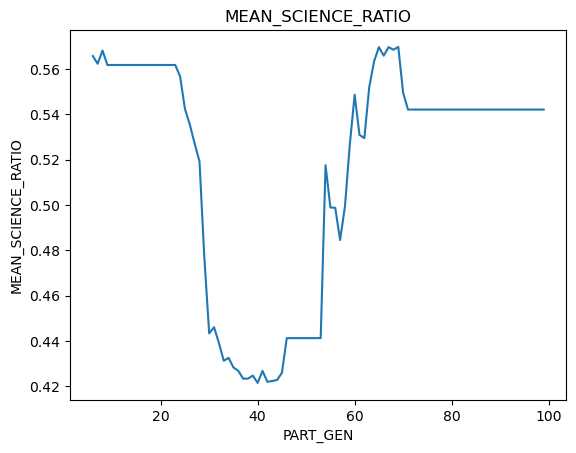

<Figure size 640x480 with 0 Axes>

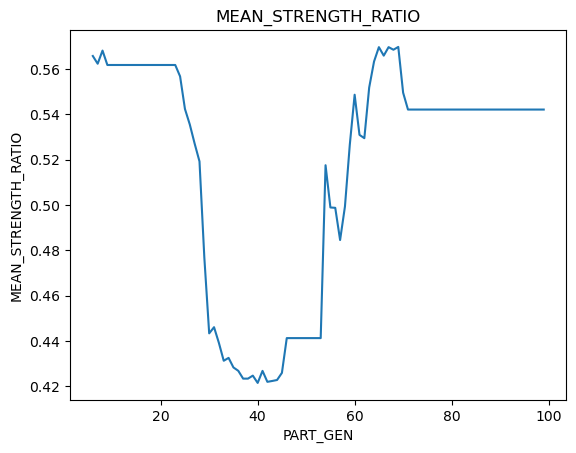

<Figure size 640x480 with 0 Axes>

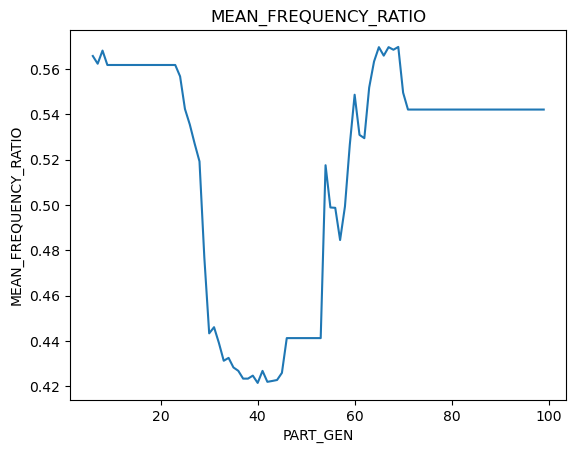

<Figure size 640x480 with 0 Axes>

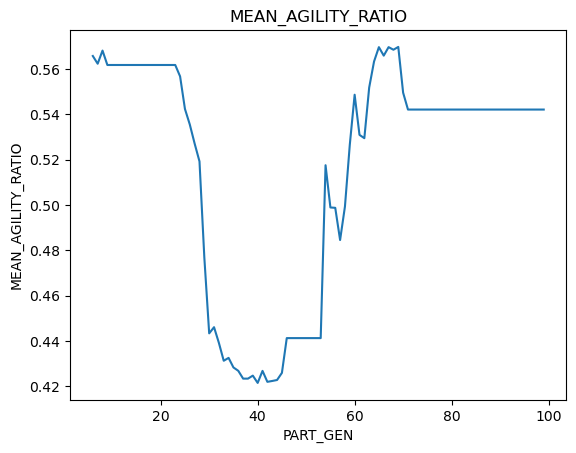

<Figure size 640x480 with 0 Axes>

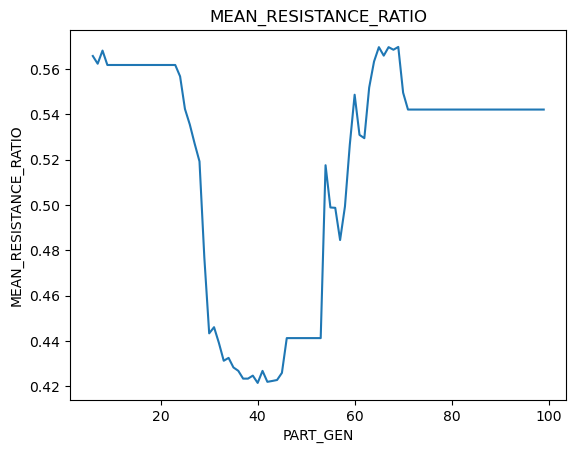

<Figure size 640x480 with 0 Axes>

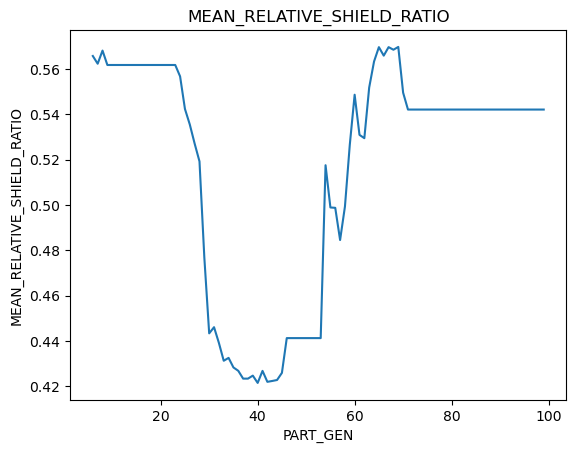

<Figure size 640x480 with 0 Axes>

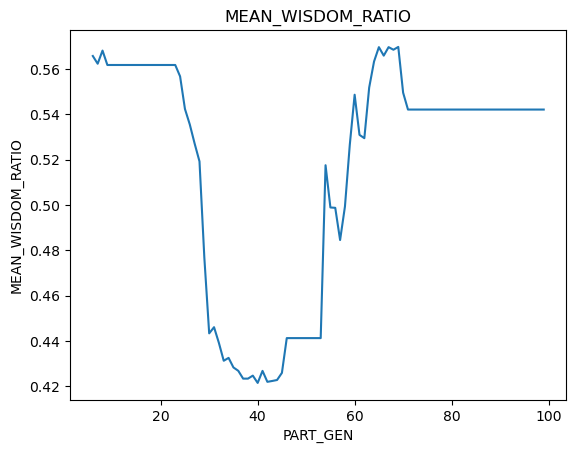

<Figure size 640x480 with 0 Axes>

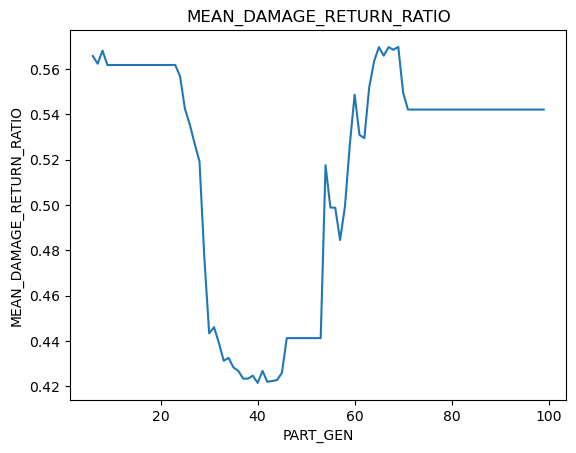

<Figure size 640x480 with 0 Axes>

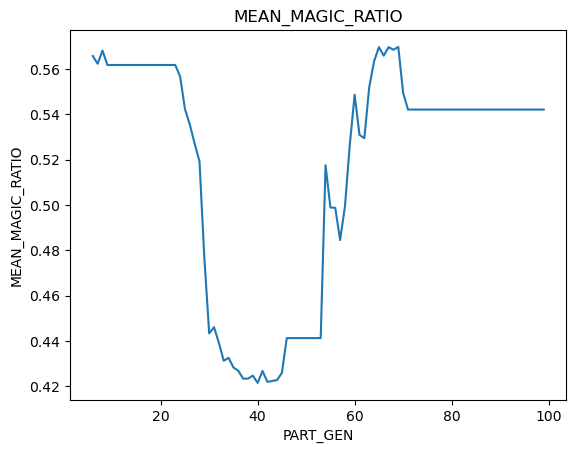

<Figure size 640x480 with 0 Axes>

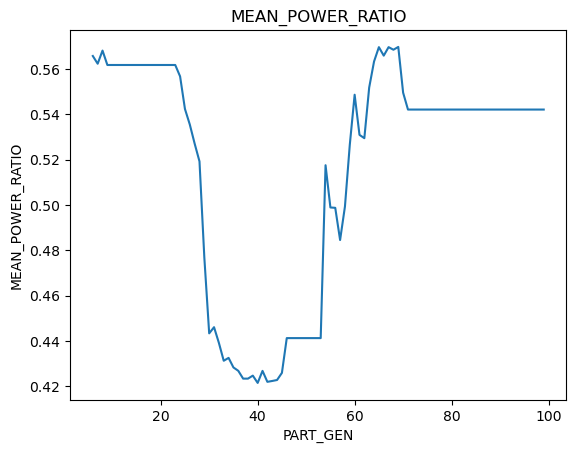

<Figure size 640x480 with 0 Axes>

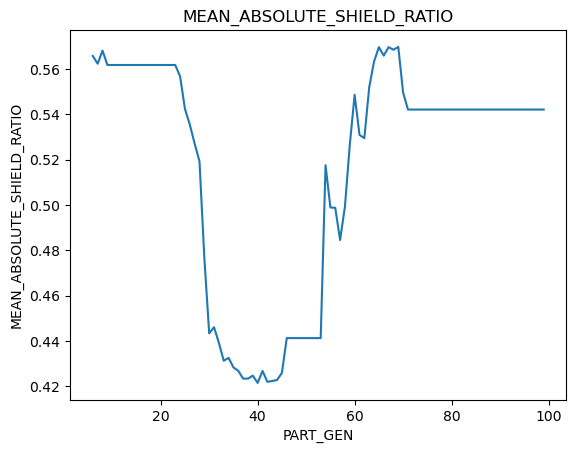

<Figure size 640x480 with 0 Axes>

In [225]:
from matplotlib import pyplot as plt

for str_col_u in df_means.columns[:-1]:
    fig = plt.figure()
    plt.plot(  df_means["PART_GEN"].ffill().tolist(),df_means[str_col_u].ffill().tolist())
    plt.ylabel(str_col_u)
    plt.xlabel("PART_GEN")
    title_ = str_col_u
    plt.title( title_)
     #axis[int(row.values[1])].set_title("( GEN_"+str(row.values[0]) + " : "+"TURN_"+str(row.values[1])+" )" )
    f_str = title_+".png"
    plt.show()
    fig.savefig(os.path.join(s_path,f_str), dpi=fig.dpi)
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()
        